<a href="https://colab.research.google.com/github/burakemretetik/micrograd/blob/main/micrograd_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Micrograd

## Import the Libraries

In [1]:
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
%matplotlib inline

## Defining Classes and Functions

In [3]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [4]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

## Backpropagation

In [5]:
# Build a multi-layer-perceptron

x = [2.0, 3.0, -1.0]
n = MLP(3,[4, 4, 1])
n(x)

Value(data=0.047473535470355585, grad=0)

In [6]:
# Define xs, ys, ypred, and loss

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.978540102739598, grad=0)

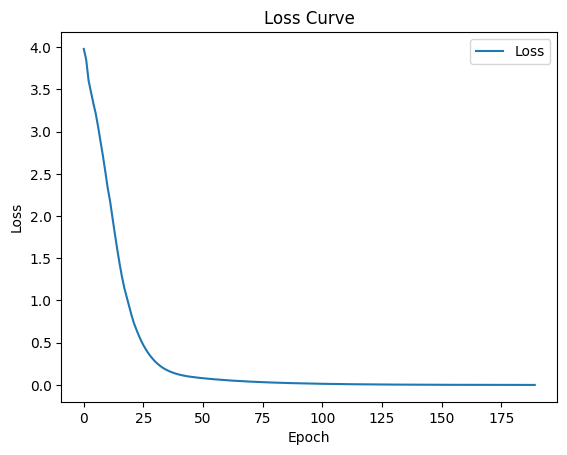

In [7]:
# Initialize lists to store loss values
loss_history = []

# Training loop
for epoch in range(190):  # Adjust the number of epochs as needed
    # Forward pass: compute predictions
    ypred = [n(x) for x in xs]

    # Compute loss
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss_history.append(loss.data)  # Store the loss value

    # Backward pass: compute gradients
    loss.backward()

    # Update weights
    for p in n.parameters():
        p.data -= 0.01 * p.grad  # Learning rate of 0.01

    # Zero the gradients for the next iteration
    for p in n.parameters():
        p.grad = 0.0

# Plot the loss curve
plt.plot(loss_history, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

## Implementation on Wine Dataset

In [13]:
from sklearn.datasets import load_wine

# Load the dataset
wine = load_wine()

# Features (Xs)
X = wine.data  # Shape: (178, 13)

# Target labels (ys)
y = wine.target  # Shape: (178,)

# Feature names
feature_names = wine.feature_names  # List of 13 feature names

# Class names
class_names = wine.target_names  # List of 3 class names

In [22]:
feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [23]:
class_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [25]:
# Compute mean and standard deviation for each feature
mean = np.mean(X, axis=0)  # Mean of each column (feature)
std = np.std(X, axis=0)    # Standard deviation of each column (feature)

# Standardize the features
X_scaled = (X - mean) / std

In [28]:
# Set a random seed for reproducibility
np.random.seed(24)

# Shuffle the dataset
indices = np.arange(len(X))  # Create an array of indices
np.random.shuffle(indices)   # Shuffle the indices

# Split into training and testing sets
test_size = 0.2  # 20% of the data for testing
split_index = int(len(X) * (1 - test_size))  # Calculate the split index

# Split the features (X) and labels (y)
X_train, X_test = X[indices[:split_index]], X[indices[split_index:]]
y_train, y_test = y[indices[:split_index]], y[indices[split_index:]]